# **ML Forecasting Project: Forecast Household Energy Consumption**

# 1. Import necessary libraries

Project Overview

* This notebook performs a complete end-to-end analysis and modeling of household energy consumption data.

Objectives:

* Forecast NEXT-DAY household energy consumption (Appliances) using time-series ML
* Classify energy consumption into three categories: Low, Medium, High

Dataset:

* 10-minute interval data
* Target variable: Appliances
* Features: Indoor temperatures (T1-T9), Indoor humidity (RH_1-RH_9), Outdoor weather, lights

In [1]:
# ============================================================================
# 1. IMPORT ALL NECESSARY LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Try importing XGBoost and LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Will skip XGBoost model.")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM not available. Will skip LightGBM model.")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("LIBRARIES IMPORTED SUCCESSFULLY")
print("=" * 80)

LIBRARIES IMPORTED SUCCESSFULLY


In [2]:
# ============================================================================
# 2. LOAD THE DATASET
# ============================================================================

print("\n" + "=" * 80)
print("LOADING DATASET")
print("=" * 80)

# Load the dataset - try multiple possible locations and filenames
data_files = [
    '../data/energydata.csv'
]

df = None
for data_file in data_files:
    try:
        df = pd.read_csv(data_file)
        print(f"Loaded dataset from: {data_file}")
        break
    except FileNotFoundError:
        continue

if df is None:
    raise FileNotFoundError(
        f"Could not find dataset. Tried: {', '.join(data_files)}\n"
        "Please ensure the CSV file is in the current directory or data/ subdirectory."
    )

# Parse 'date' column as datetime and set as index
# Check if 'date' column exists, if not check for 'Date' or timestamp column
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
elif 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
else:
    # If no date column, check if index is already datetime or create from first column
    if df.index.dtype == 'object':
        try:
            df.index = pd.to_datetime(df.index)
        except:
            print("Warning: Could not parse index as datetime. Creating date range.")
            df.index = pd.date_range(start='2016-01-01', periods=len(df), freq='10min')
    elif not isinstance(df.index, pd.DatetimeIndex):
        print("Warning: No date column found. Creating date range.")
        df.index = pd.date_range(start='2016-01-01', periods=len(df), freq='10min')

print(f"Dataset loaded. Shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:")
print(df.head())


LOADING DATASET
Loaded dataset from: ../data/energydata.csv
Dataset loaded. Shape: (19735, 28)
Date range: 2016-01-11 17:00:00 to 2016-05-27 18:00:00

First few rows:
                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4  ...         T9  \
date                                                         ...              
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...  17.033333   
2016-01-11 17:10:00  19.79  44.790000  19.000000

In [3]:
#============================================================================
# 3. BASIC DATA EXPLORATION
# ============================================================================

print("\n" + "=" * 80)
print("BASIC DATA EXPLORATION")
print("=" * 80)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())



BASIC DATA EXPLORATION

Dataset shape: (19735, 28)

Column names:
['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']


In [4]:
print(f"\nData info:")
df.info()


Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18 

In [5]:
print(f"\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0])
if missing.sum() == 0:
    print("No missing values found.")



Missing values:
Series([], dtype: int64)
No missing values found.


In [6]:
print(f"\nBasic statistics:")
df.describe()


Basic statistics:


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [7]:
# Create a dictionary to map current column names to new column names
column_mapping = {'T1': 'KITCHEN_TEMP',
    'RH_1': 'KITCHEN_HUM',
    'T2': 'LIVING_TEMP',
    'RH_2' :'LIVING_HUM',
    'T3': 'BEDROOM_TEMP',
    'RH_3':'BEDROOM_HUM',
    'T4' : 'OFFICE_TEMP',
    'RH_4' : 'OFFICE_HUM',
    'T5' : 'BATHROOM_TEMP',
    'RH_5': 'BATHROOM_HUM',
    'T6':'OUTSIDE_TEMP_build',
    'RH_6': 'OUTSIDE_HUM_build',
    'T7': 'IRONING_ROOM_TEMP',
    'RH_7' : 'IRONING_ROOM_HUM',
    'T8' :'TEEN_ROOM_2_TEMP',
    'RH_8' : 'TEEN_ROOM_HUM',
    'T9': 'PARENTS_ROOM_TEMP',
    'RH_9': 'PARENTS_ROOM_HUM',
    'T_out' :'OUTSIDE_TEMP_wstn',
    'RH_out' :'OUTSIDE_HUM_wstn'}

# Rename the columns using the mapping
df.rename(columns=column_mapping, inplace=True)

In [8]:
# ============================================================================
# 4. PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("PREPROCESSING")
print("=" * 80)

# Resample to daily frequency
print("\nResampling to daily frequency...")
print("  - Summing 'Appliances' and 'lights'")
print("  - Taking mean for all other columns")

# Check if 'Appliances' and 'lights' columns exist
if 'Appliances' not in df.columns:
    # Try to find similar column names
    app_cols = [col for col in df.columns if 'appliance' in col.lower() or 'appliances' in col.lower()]
    if app_cols:
        df['Appliances'] = df[app_cols[0]]
    else:
        raise ValueError("'Appliances' column not found in dataset")

if 'lights' not in df.columns:
    light_cols = [col for col in df.columns if 'light' in col.lower() or 'lights' in col.lower()]
    if light_cols:
        df['lights'] = df[light_cols[0]]
    else:
        df['lights'] = 0  # Set to 0 if not found

# Create aggregation dictionary
agg_dict = {}
for col in df.columns:
    if col in ['Appliances', 'lights']:
        agg_dict[col] = 'sum'
    else:
        agg_dict[col] = 'mean'

# Resample to daily
df_daily = df.resample('D').agg(agg_dict)

print(f"Daily data shape: {df_daily.shape}")
print(f"Date range: {df_daily.index.min()} to {df_daily.index.max()}")


PREPROCESSING

Resampling to daily frequency...
  - Summing 'Appliances' and 'lights'
  - Taking mean for all other columns
Daily data shape: (138, 28)
Date range: 2016-01-11 00:00:00 to 2016-05-27 00:00:00


In [9]:


# Forward fill any missing values after resampling
print("\nForward filling missing values...")
df_daily = df_daily.ffill().bfill()


Forward filling missing values...


In [10]:
# Apply winsorization (clip at 1% and 99%) to 'Appliances' to handle outliers
print("\nApplying winsorization to 'Appliances' (clip at 1% and 99%)...")
lower_bound = df_daily['Appliances'].quantile(0.01)
upper_bound = df_daily['Appliances'].quantile(0.99)
print(f"  Lower bound (1%): {lower_bound:.2f}")
print(f"  Upper bound (99%): {upper_bound:.2f}")
df_daily['Appliances'] = df_daily['Appliances'].clip(lower=lower_bound, upper=upper_bound)


Applying winsorization to 'Appliances' (clip at 1% and 99%)...
  Lower bound (1%): 6047.10
  Upper bound (99%): 25458.30


In [11]:


# Optional: apply log1p transform to 'Appliances' if highly skewed
print("\nChecking skewness of 'Appliances'...")
skewness = df_daily['Appliances'].skew()
print(f"  Skewness: {skewness:.2f}")
if abs(skewness) > 1.5:
    print("  Applying log1p transform (highly skewed)...")
    df_daily['Appliances'] = np.log1p(df_daily['Appliances'])
    APPLY_LOG_TRANSFORM = True
else:
    print("  Skewness is acceptable, no log transform needed.")
    APPLY_LOG_TRANSFORM = False


Checking skewness of 'Appliances'...
  Skewness: 0.78
  Skewness is acceptable, no log transform needed.


In [12]:
print(f"\nPreprocessed data shape: {df_daily.shape}")
print(f"Preprocessed data head:")
df_daily.head()


Preprocessed data shape: (138, 28)
Preprocessed data head:


,Appliances,lights,KITCHEN_TEMP,KITCHEN_HUM,LIVING_TEMP,LIVING_HUM,BEDROOM_TEMP,BEDROOM_HUM,OFFICE_TEMP,OFFICE_HUM,...,PARENTS_ROOM_TEMP,PARENTS_ROOM_HUM,OUTSIDE_TEMP_wstn,Press_mm_hg,OUTSIDE_HUM_wstn,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,6047.1,1260,20.808571,46.906210,20.153333,44.793175,20.140972,45.992440,19.492222,47.260813,...,16.918175,45.106210,5.922619,735.173810,89.285714,6.083333,40.845238,4.228571,26.248800,26.248800
2016-01-12,12340.0,610,20.092326,45.142014,19.307655,43.779733,19.993646,44.933171,19.772778,44.556840,...,17.032847,45.680127,5.566319,742.628125,87.500000,5.784722,37.229167,3.596528,25.505072,25.505072
2016-01-13,13970.0,780,19.197824,42.867772,18.568513,42.119669,19.609213,43.720891,19.009803,42.315174,...,16.953576,44.691476,4.856944,754.790625,83.406250,5.614583,31.559028,2.169792,23.464726,23.464726
2016-01-14,21800.0,720,20.372078,42.435191,19.743131,40.699172,20.837581,43.399740,18.694271,43.231053,...,16.884815,45.428229,3.431944,749.767361,86.420139,6.277778,35.149306,1.316667,25.264569,25.264569
2016-01-15,18050.0,860,22.280949,39.099294,21.528172,38.193897,20.959074,41.409884,19.615127,41.961036,...,17.345694,44.534329,2.665278,754.579861,88.385417,7.770833,40.208333,0.849653,26.289515,26.289515


# 4. Exploratory Data Analysis


EXPLORATORY DATA ANALYSIS

Plotting target distribution...


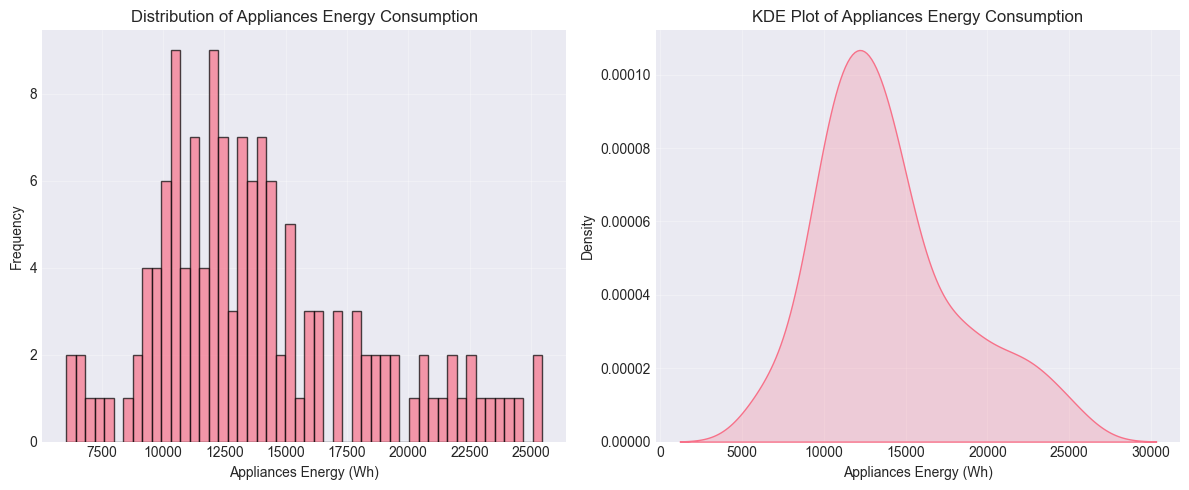

In [13]:
# ============================================================================
# 5. EXPLORATORY DATA ANALYSIS (WITH PLOTS)
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Plot target distribution (histogram + KDE)
print("\nPlotting target distribution...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_daily['Appliances'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Appliances Energy (Wh)')
plt.ylabel('Frequency')
plt.title('Distribution of Appliances Energy Consumption')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.kdeplot(df_daily['Appliances'], fill=True)
plt.xlabel('Appliances Energy (Wh)')
plt.ylabel('Density')
plt.title('KDE Plot of Appliances Energy Consumption')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Plotting time series of Appliances...


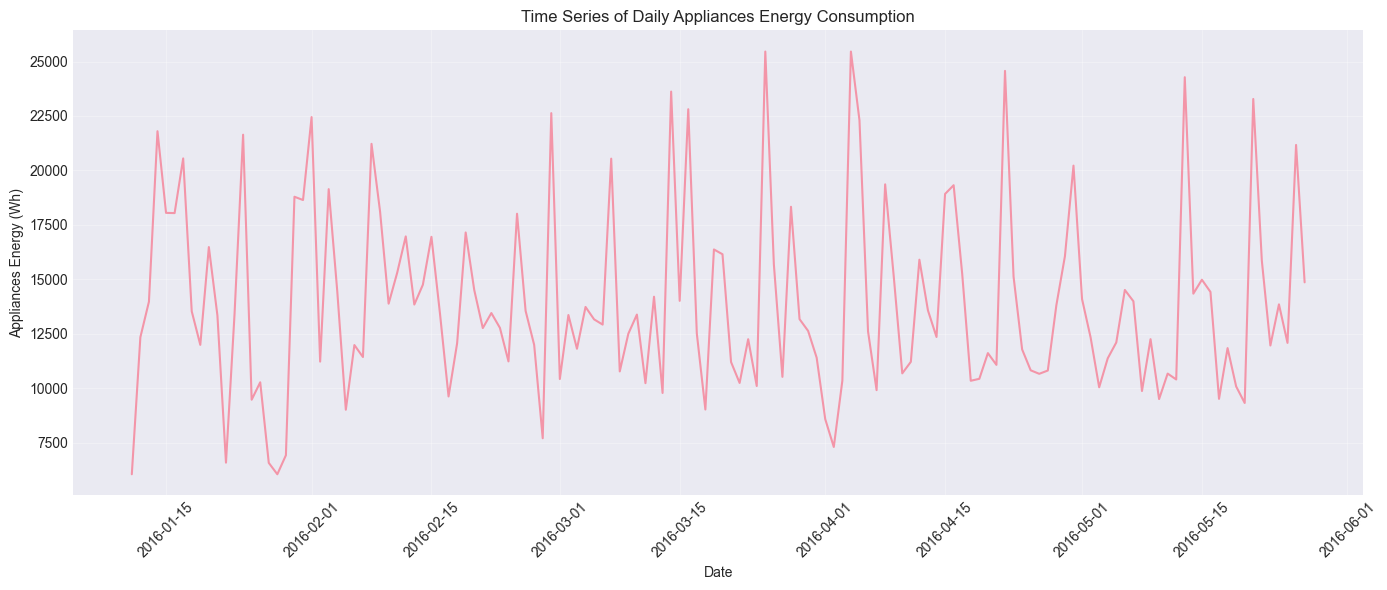

In [14]:
# Plot time series of Appliances over time
print("\nPlotting time series of Appliances...")
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['Appliances'], linewidth=1.5, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Appliances Energy (Wh)')
plt.title('Time Series of Daily Appliances Energy Consumption')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Plotting monthly average consumption...


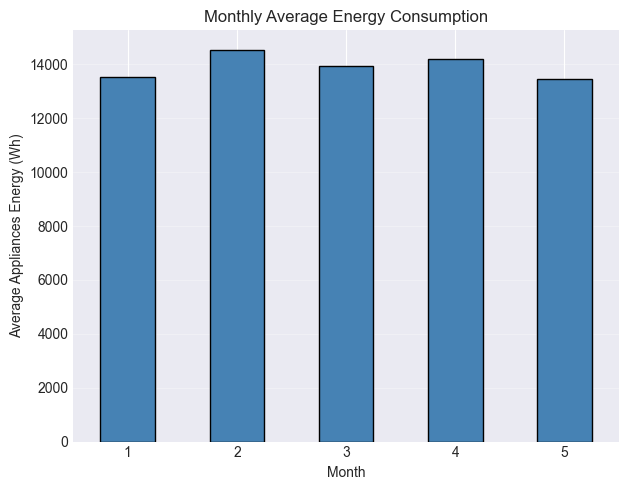

In [15]:
# Plot monthly average consumption
print("\nPlotting monthly average consumption...")
df_daily['month'] = df_daily.index.month
monthly_avg = df_daily.groupby('month')['Appliances'].mean()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
monthly_avg.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Average Appliances Energy (Wh)')
plt.title('Monthly Average Energy Consumption')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()


Plotting day-of-week average consumption...


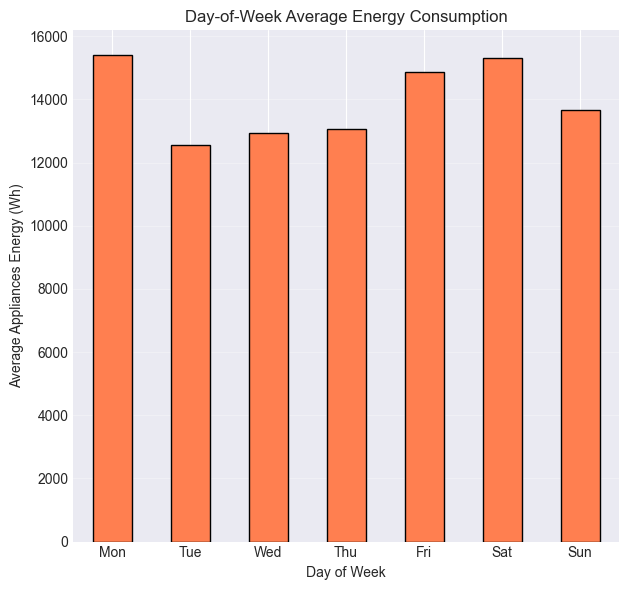

In [16]:
# Plot day-of-week average consumption
print("\nPlotting day-of-week average consumption...")
df_daily['day_of_week'] = df_daily.index.dayofweek
dow_avg = df_daily.groupby('day_of_week')['Appliances'].mean()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.subplot(1, 2, 2)
dow_avg.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('Day of Week')
plt.ylabel('Average Appliances Energy (Wh)')
plt.title('Day-of-Week Average Energy Consumption')
plt.xticks(range(7), dow_names, rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


Plotting autocorrelation (up to 30 lags)...


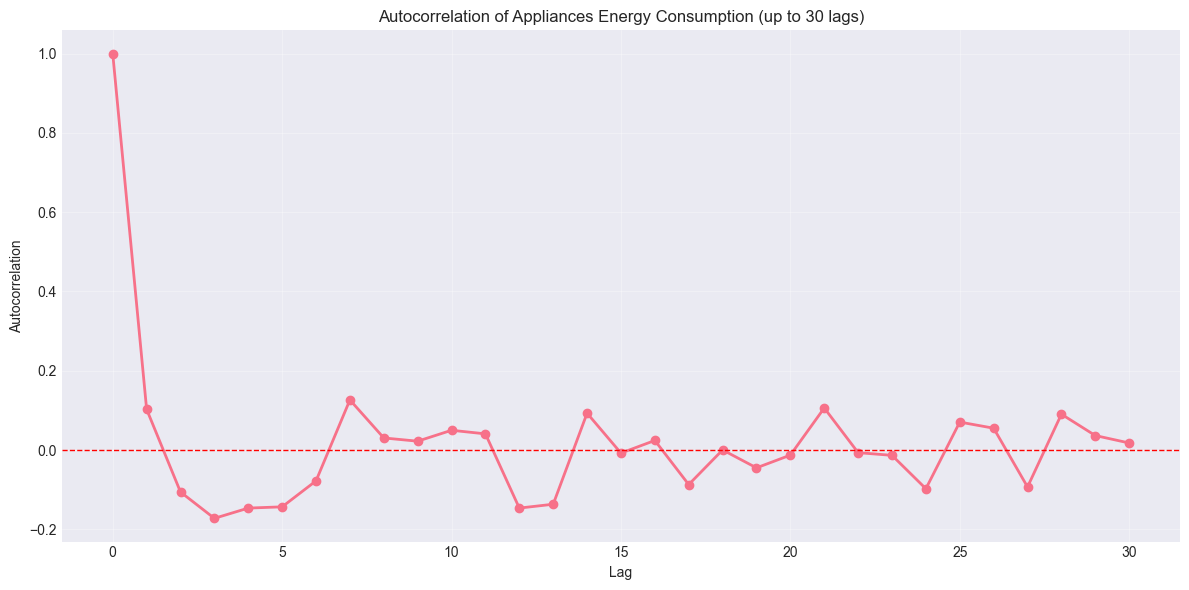

In [17]:
# Plot autocorrelation (up to 30 lags)
print("\nPlotting autocorrelation (up to 30 lags)...")
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 6))
autocorr = [df_daily['Appliances'].autocorr(lag=i) for i in range(31)]
plt.plot(range(31), autocorr, marker='o', linewidth=2, markersize=6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Appliances Energy Consumption (up to 30 lags)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# feature engineering

In [20]:
# ============================================================================
# 6. FEATURE ENGINEERING (ALL IN ONE PLACE)
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Create a copy for feature engineering
df_features = df_daily.copy()

# Create date features
print("\nCreating date features...")
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['quarter'] = df_features.index.quarter
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
df_features['day_of_month'] = df_features.index.day
df_features[['day_of_week', 'month', 'quarter', 'is_weekend', 'day_of_month']]


FEATURE ENGINEERING

Creating date features...


,day_of_week,month,quarter,is_weekend,day_of_month
date,,,,,
2016-01-11,0,1,1,0,11
2016-01-12,1,1,1,0,12
2016-01-13,2,1,1,0,13
2016-01-14,3,1,1,0,14
2016-01-15,4,1,1,0,15
...,...,...,...,...,...
2016-05-23,0,5,2,0,23
2016-05-24,1,5,2,0,24
2016-05-25,2,5,2,0,25


In [21]:
# Create lag features
print("Creating lag features...")
df_features['Appliances_lag_1'] = df_features['Appliances'].shift(1)
df_features['Appliances_lag_3'] = df_features['Appliances'].shift(3)
df_features['Appliances_lag_7'] = df_features['Appliances'].shift(7)

df_features[['Appliances_lag_1', 'Appliances_lag_3', 'Appliances_lag_7']].head(10)

Creating lag features...


,Appliances_lag_1,Appliances_lag_3,Appliances_lag_7
date,,,
2016-01-11,NaN,NaN,NaN
2016-01-12,6047.1,NaN,NaN
2016-01-13,12340.0,NaN,NaN
2016-01-14,13970.0,6047.1,NaN
2016-01-15,21800.0,12340.0,NaN
2016-01-16,18050.0,13970.0,NaN
2016-01-17,18040.0,21800.0,NaN
2016-01-18,20550.0,18050.0,6047.1
2016-01-19,13530.0,18040.0,12340.0


In [22]:

# Create rolling features
print("Creating rolling features...")
df_features['Appliances_rolling_mean_7'] = df_features['Appliances'].rolling(window=7, min_periods=1).mean()
df_features['Appliances_rolling_std_7'] = df_features['Appliances'].rolling(window=7, min_periods=1).std()

df_features[['Appliances_rolling_mean_7', 'Appliances_rolling_std_7']].head(10)

Creating rolling features...


,Appliances_rolling_mean_7,Appliances_rolling_std_7
date,,
2016-01-11,6047.100000,NaN
2016-01-12,9193.550000,4449.752263
2016-01-13,10785.700000,4183.894414
2016-01-14,13539.275000,6480.639071
2016-01-15,14441.420000,5963.919859
2016-01-16,15041.183333,5532.898734
2016-01-17,15828.157143,5463.158559
2016-01-18,16897.142857,3667.195633
2016-01-19,16847.142857,3741.322023


In [23]:
# Create sequence features: last 7 days as separate columns
print("Creating sequence features (last 7 days)...")
for i in range(1, 8):
    df_features[f'Appliances_seq_{i}'] = df_features['Appliances'].shift(i)

df_features[[f'Appliances_seq_{i}' for i in range(1, 8)]].head(10)

Creating sequence features (last 7 days)...


,Appliances_seq_1,Appliances_seq_2,Appliances_seq_3,Appliances_seq_4,Appliances_seq_5,Appliances_seq_6,Appliances_seq_7
date,,,,,,,
2016-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-12,6047.1,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-13,12340.0,6047.1,NaN,NaN,NaN,NaN,NaN
2016-01-14,13970.0,12340.0,6047.1,NaN,NaN,NaN,NaN
2016-01-15,21800.0,13970.0,12340.0,6047.1,NaN,NaN,NaN
2016-01-16,18050.0,21800.0,13970.0,12340.0,6047.1,NaN,NaN
2016-01-17,18040.0,18050.0,21800.0,13970.0,12340.0,6047.1,NaN
2016-01-18,20550.0,18040.0,18050.0,21800.0,13970.0,12340.0,6047.1
2016-01-19,13530.0,20550.0,18040.0,18050.0,21800.0,13970.0,12340.0


In [24]:
# Drop rows with NaN introduced by lags/rolling
print("\nDropping rows with NaN from lags/rolling...")
initial_shape = df_features.shape[0]
df_features = df_features.dropna()
final_shape = df_features.shape[0]
print(f"  Dropped {initial_shape - final_shape} rows")
print(f"  Final shape: {df_features.shape}")

print(f"\nFeature engineering complete. Total features: {df_features.shape[1]}")
print(f"Feature columns: {df_features.columns.tolist()}")



Dropping rows with NaN from lags/rolling...
  Dropped 7 rows
  Final shape: (131, 45)

Feature engineering complete. Total features: 45
Feature columns: ['Appliances', 'lights', 'KITCHEN_TEMP', 'KITCHEN_HUM', 'LIVING_TEMP', 'LIVING_HUM', 'BEDROOM_TEMP', 'BEDROOM_HUM', 'OFFICE_TEMP', 'OFFICE_HUM', 'BATHROOM_TEMP', 'BATHROOM_HUM', 'OUTSIDE_TEMP_build', 'OUTSIDE_HUM_build', 'IRONING_ROOM_TEMP', 'IRONING_ROOM_HUM', 'TEEN_ROOM_2_TEMP', 'TEEN_ROOM_HUM', 'PARENTS_ROOM_TEMP', 'PARENTS_ROOM_HUM', 'OUTSIDE_TEMP_wstn', 'Press_mm_hg', 'OUTSIDE_HUM_wstn', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'month', 'day_of_week', 'quarter', 'is_weekend', 'day_of_month', 'Appliances_lag_1', 'Appliances_lag_3', 'Appliances_lag_7', 'Appliances_rolling_mean_7', 'Appliances_rolling_std_7', 'Appliances_seq_1', 'Appliances_seq_2', 'Appliances_seq_3', 'Appliances_seq_4', 'Appliances_seq_5', 'Appliances_seq_6', 'Appliances_seq_7']


In [27]:
print(df_features.isnull().sum().sum())

0


# train test split

In [28]:
# ============================================================================
# 7. TRAIN-TEST SPLIT (TIME-SERIES AWARE)
# ============================================================================

print("\n" + "=" * 80)
print("TRAIN-TEST SPLIT (TIME-SERIES AWARE)")
print("=" * 80)

# Separate target and features
target = 'Appliances'
feature_cols = [col for col in df_features.columns if col != target]

# Use last 20% of data as test set (temporal order preserved)
split_idx = int(len(df_features) * 0.8)
train_df = df_features.iloc[:split_idx].copy()
test_df = df_features.iloc[split_idx:].copy()

X_train = train_df[feature_cols]
y_train = train_df[target]
X_test = test_df[feature_cols]
y_test = test_df[target]

print(f"Train set size: {len(X_train)} ({len(X_train)/len(df_features)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df_features)*100:.1f}%)")
print(f"Train date range: {train_df.index.min()} to {train_df.index.max()}")
print(f"Test date range: {test_df.index.min()} to {test_df.index.max()}")



TRAIN-TEST SPLIT (TIME-SERIES AWARE)
Train set size: 104 (79.4%)
Test set size: 27 (20.6%)
Train date range: 2016-01-18 00:00:00 to 2016-04-30 00:00:00
Test date range: 2016-05-01 00:00:00 to 2016-05-27 00:00:00


# Encoding

In [30]:
# ============================================================================
# 8. ENCODING 
# ============================================================================

print("\n" + "=" * 80)
print("ENCODING AND SCALING")
print("=" * 80)

# Identify categorical features
categorical_features = ['day_of_week', 'month', 'quarter']
categorical_features = [f for f in categorical_features if f in feature_cols]

from sklearn.preprocessing import LabelEncoder

# Label encode categorical features (robust to unseen categories in test)
print("\nLabel encoding categorical features...")

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    
    # Fit the encoder on the training data
    le.fit(X_train[col])
    
    # Transform training data (safe)
    X_train_encoded[col] = le.transform(X_train[col])
    
    # Transform test data: map unseen categories to a safe default (e.g., -1 or most common)
    # We'll map unseen labels to the most frequent class in training (common practice)
    most_frequent = le.transform([le.classes_[0]])[0]  # or use mode
    
    def safe_transform(values):
        return pd.Series(values).apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else most_frequent
        ).values
    
    X_test_encoded[col] = safe_transform(X_test[col])
    
    label_encoders[col] = le

print(f"Label encoding completed for {len(categorical_features)} features: {categorical_features}")

# No need for column alignment since we're not adding new columns (unlike one-hot)
# Both train and test still have exactly the same columns

print(f"  Categorical features encoded: {categorical_features}")
print(f"  Total features after encoding: {X_train_encoded.shape[1]}")


ENCODING AND SCALING

Label encoding categorical features...
Label encoding completed for 3 features: ['day_of_week', 'month', 'quarter']
  Categorical features encoded: ['day_of_week', 'month', 'quarter']
  Total features after encoding: 44


# Scaling

In [31]:
# ============================================================================
# Prepare full dataset — re-fit everything on full data (cleanest approach)
# ============================================================================

print("\nPreparing full dataset for final retraining (re-fitting preprocessing)...")

X_full_processed = df_features[feature_cols].copy()

# Label encode on full data (no risk of unseen categories)
for col in categorical_features:
    le = LabelEncoder()
    X_full_processed[col] = le.fit_transform(X_full_processed[col])

# Re-fit the scaler on the full processed data
scaler_full = StandardScaler()
X_full_scaled = pd.DataFrame(
    scaler_full.fit_transform(X_full_processed),
    columns=X_full_processed.columns,
    index=df_features.index
)

y_full = df_features[target]

print(f"Full dataset ready: {X_full_scaled.shape[0]} samples, {X_full_scaled.shape[1]} features")


Preparing full dataset for final retraining (re-fitting preprocessing)...
Full dataset ready: 131 samples, 44 features


In [32]:
X_full_scaled.head()

,lights,KITCHEN_TEMP,KITCHEN_HUM,LIVING_TEMP,LIVING_HUM,BEDROOM_TEMP,BEDROOM_HUM,OFFICE_TEMP,OFFICE_HUM,BATHROOM_TEMP,...,Appliances_lag_7,Appliances_rolling_mean_7,Appliances_rolling_std_7,Appliances_seq_1,Appliances_seq_2,Appliances_seq_3,Appliances_seq_4,Appliances_seq_5,Appliances_seq_6,Appliances_seq_7
date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,-0.079082,-1.109682,0.181166,-0.897934,0.150212,-1.213435,0.593012,-0.695297,-0.162310,-0.882415,...,-1.813569,2.330106,-0.411323,1.548079,0.976092,0.964934,1.805379,-0.007722,-0.378586,-1.813569
2016-01-19,-0.297181,-1.666138,-0.132205,-1.284552,-0.124450,-1.525690,0.316512,-1.209976,-0.290799,-1.487417,...,-0.350014,2.290775,-0.356203,-0.087530,1.565284,0.962593,0.938737,1.803357,-0.001508,-0.350014
2016-01-20,0.684266,-2.150456,-0.533852,-1.537334,-0.653375,-1.925677,-0.120363,-1.801550,-0.391750,-1.539575,...,0.029079,2.572837,-0.510248,-0.446339,-0.082577,1.550076,0.936426,0.935982,1.809858,0.029079
2016-01-21,0.139018,-1.818520,-0.561369,-1.157320,-0.973033,-1.906267,0.091158,-1.620690,-0.367936,-1.482012,...,1.850122,1.622140,-0.815298,0.599798,-0.444074,-0.093004,1.516498,0.933669,0.942346,1.850122
2016-01-22,-0.929670,-2.137543,-0.378052,-1.521396,-0.442069,-1.925084,0.212724,-2.371429,0.002769,-1.832934,...,0.977975,0.333193,0.245302,-0.131799,0.609900,-0.453452,-0.105856,1.514232,0.940032,0.977975


In [33]:
y_full.head()

date
2016-01-18    13530.0
2016-01-19    11990.0
2016-01-20    16480.0
2016-01-21    13340.0
2016-01-22     6580.0
Freq: D, Name: Appliances, dtype: float64


FEATURE IMPORTANCE ANALYSIS (Proxy Model for Selection)
Training proxy RandomForest on full data to compute feature importance...
Proxy model trained.

Top 20 Most Important Features:
                      feature  importance
0                      lights    0.110758
1   Appliances_rolling_mean_7    0.090582
2    Appliances_rolling_std_7    0.068287
3            Appliances_seq_3    0.059742
4            Appliances_lag_3    0.050395
5                BEDROOM_TEMP    0.047774
6            Appliances_seq_2    0.038076
7            Appliances_lag_1    0.035367
8               TEEN_ROOM_HUM    0.030113
9            Appliances_seq_1    0.027996
10                Press_mm_hg    0.025174
11                  Windspeed    0.024151
12           Appliances_seq_7    0.023117
13              BATHROOM_TEMP    0.021309
14               day_of_month    0.020721
15           Appliances_lag_7    0.019525
16           Appliances_seq_6    0.017626
17           Appliances_seq_4    0.017479
18           Appl

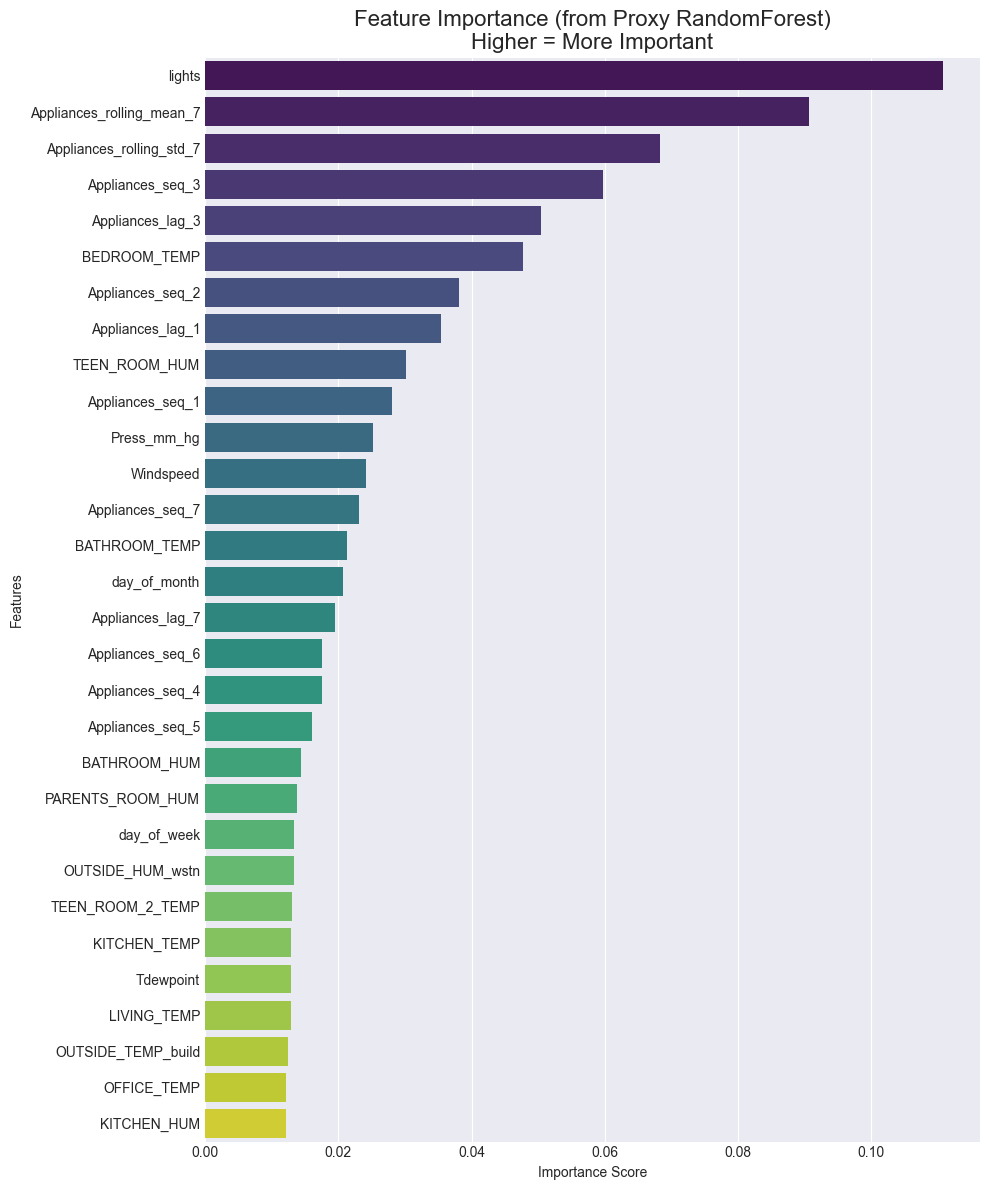


Cumulative Importance:
Number of features needed for...
  80% of total importance: 24 features
  90% of total importance: 32 features
  95% of total importance: 36 features
  99% of total importance: 41 features

Features with importance < 0.001 (candidates for removal): 1
['quarter']


In [35]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS (Before Final Training - For Feature Selection)
# ============================================================================

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS (Proxy Model for Selection)")
print("=" * 80)

# Use a quick RandomForest as proxy to estimate importance
# (Fast and reliable for ranking features)
proxy_model = RandomForestRegressor(
    n_estimators=200,      # More trees = better importance estimate
    random_state=42,
    n_jobs=-1,
    max_depth=None         # Let it grow fully for accurate splits
)

print("Training proxy RandomForest on full data to compute feature importance...")
proxy_model.fit(X_full_scaled, y_full)
print("Proxy model trained.")

# Get feature importances
importances = proxy_model.feature_importances_
feature_names = X_full_scaled.columns

# Create DataFrame and sort
feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Display top features
print("\nTop 20 Most Important Features:")
print(feat_importance.head(20))

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(
    data=feat_importance.head(30),   # Show top 30
    y='feature',
    x='importance',
    palette='viridis'
)
plt.title('Feature Importance (from Proxy RandomForest)\nHigher = More Important', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Optional: Cumulative importance to decide cutoff
feat_importance['cumulative'] = feat_importance['importance'].cumsum()
print(f"\nCumulative Importance:")
print("Number of features needed for...")
for thresh in [0.80, 0.90, 0.95, 0.99]:
    n_features = (feat_importance['cumulative'] >= thresh).idxmax() + 1
    print(f"  {thresh*100:.0f}% of total importance: {n_features} features")

# Example: Features with very low importance (< 0.001)
low_importance = feat_importance[feat_importance['importance'] < 0.001]
print(f"\nFeatures with importance < 0.001 (candidates for removal): {len(low_importance)}")
print(low_importance['feature'].tolist())

In [ ]:
# ============================================================================
# FEATURE SELECTION: Remove Low-Importance Columns
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE SELECTION BASED ON PROXY RANDOMFOREST IMPORTANCE")
print("=" * 80)

# From your plot, these are clearly near-zero importance (bottom ~15 features)
low_importance_features = [
    'KITCHEN_HUM',
    'OFFICE_TEMP',
    'OUTSIDE_TEMP_build',
    'LIVING_TEMP',
    'Tdewpoint',
    'KITCHEN_TEMP',
    'TEEN_ROOM_2_TEMP',
    'OUTSIDE_HUM_wstn',
    'day_of_week',
    'PARENTS_ROOM_HUM',
    'BATHROOM_HUM',
    'Appliances_seq_5',
    'Appliances_seq_4',
    'Appliances_seq_6',
    'Appliances_lag_7',
    'day_of_month',
    'BATHROOM_TEMP',
    'Appliances_seq_7',
    'Windspeed',              # borderline — keep if you want weather
    'Press_mm_hg',             # borderline — keep if you want
]

df_features = df_features.drop(columns=low_importance_features,axis=True,inplace=True)


FEATURE SELECTION BASED ON PROXY RANDOMFOREST IMPORTANCE


In [40]:
df_features.head()

,Appliances,lights,LIVING_HUM,BEDROOM_TEMP,BEDROOM_HUM,OFFICE_HUM,OUTSIDE_HUM_build,IRONING_ROOM_TEMP,IRONING_ROOM_HUM,TEEN_ROOM_HUM,...,month,quarter,is_weekend,Appliances_lag_1,Appliances_lag_3,Appliances_rolling_mean_7,Appliances_rolling_std_7,Appliances_seq_1,Appliances_seq_2,Appliances_seq_3
date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,13530.0,490,40.927661,20.001400,40.861846,38.199196,89.639279,19.157629,35.551679,44.179900,...,1,1,0,20550.0,18050.0,16897.142857,3667.195633,20550.0,18040.0,18050.0
2016-01-19,11990.0,390,39.999439,19.395249,40.027286,37.666059,86.084550,17.930624,32.616767,42.432220,...,1,1,0,13530.0,18040.0,16847.142857,3741.322023,13530.0,20550.0,18040.0
2016-01-20,16480.0,840,38.211933,18.618791,38.708663,37.247187,92.756978,16.589257,31.757395,42.656523,...,1,1,0,11990.0,20550.0,17205.714286,3534.161179,11990.0,13530.0,20550.0
2016-01-21,13340.0,590,37.131644,18.656470,39.347101,37.345995,94.302876,16.602477,31.230922,41.518387,...,1,1,0,16480.0,13530.0,15997.142857,3123.927626,16480.0,11990.0,13530.0
2016-01-22,6580.0,100,38.926042,18.619942,39.714022,38.884155,95.203258,16.237164,33.655770,43.615023,...,1,1,0,13340.0,11990.0,14358.571429,4550.228670,13340.0,16480.0,11990.0


# Model training

In [41]:
# ============================================================================
# 9. FINAL MODEL TRAINING ON FULL DATASET
# ============================================================================

print("\n" + "=" * 80)
print("FINAL MODEL TRAINING ON FULL DATASET")
print("=" * 80)

final_models = {}

# RandomForestRegressor
print("\n1. Training RandomForestRegressor on full data...")
rf_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_full_scaled, y_full)
final_models['RandomForest'] = rf_final
print("  RandomForest final training complete.")

# XGBoost Regressor
if XGBOOST_AVAILABLE:
    print("\n2. Training XGBoost Regressor on full data...")
    xgb_final = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_final.fit(X_full_scaled, y_full)
    final_models['XGBoost'] = xgb_final
    print("  XGBoost final training complete.")
else:
    print("\n2. XGBoost skipped (not available).")

# LightGBM Regressor
if LIGHTGBM_AVAILABLE:
    print("\n3. Training LightGBM Regressor on full data...")
    lgb_final = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
    lgb_final.fit(X_full_scaled, y_full)
    final_models['LightGBM'] = lgb_final
    print("  LightGBM final training complete.")
else:
    print("\n3. LightGBM skipped (not available).")

print(f"\nFinal models trained on full dataset: {len(final_models)} models")
print("Ready for saving or deployment.")


FINAL MODEL TRAINING ON FULL DATASET

1. Training RandomForestRegressor on full data...
  RandomForest final training complete.

2. Training XGBoost Regressor on full data...
  XGBoost final training complete.

3. Training LightGBM Regressor on full data...
  LightGBM final training complete.

Final models trained on full dataset: 3 models
Ready for saving or deployment.


In [42]:
# ============================================================================
# 9. FINAL MODEL TRAINING ON FULL DATASET
# ============================================================================

print("\n" + "=" * 80)
print("FINAL MODEL TRAINING ON FULL DATASET")
print("=" * 80)

final_models = {}

# RandomForestRegressor
print("\n1. Training RandomForestRegressor on full data...")
rf_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_full_scaled, y_full)
final_models['RandomForest'] = rf_final
print("  RandomForest final training complete.")

# XGBoost Regressor
if XGBOOST_AVAILABLE:
    print("\n2. Training XGBoost Regressor on full data...")
    xgb_final = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_final.fit(X_full_scaled, y_full)
    final_models['XGBoost'] = xgb_final
    print("  XGBoost final training complete.")
else:
    print("\n2. XGBoost skipped (not available).")

# LightGBM Regressor
if LIGHTGBM_AVAILABLE:
    print("\n3. Training LightGBM Regressor on full data...")
    lgb_final = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
    lgb_final.fit(X_full_scaled, y_full)
    final_models['LightGBM'] = lgb_final
    print("  LightGBM final training complete.")
else:
    print("\n3. LightGBM skipped (not available).")

print(f"\nFinal models trained on full dataset: {len(final_models)} model(s)")

# Select the "best" model for deployment (preference order: LightGBM > XGBoost > RF)
if 'LightGBM' in final_models:
    best_model_name = 'LightGBM'
    final_model = final_models['LightGBM']
elif 'XGBoost' in final_models:
    best_model_name = 'XGBoost'
    final_model = final_models['XGBoost']
else:
    best_model_name = 'RandomForest'
    final_model = final_models['RandomForest']

print(f"\nSelected production model: {best_model_name}")


FINAL MODEL TRAINING ON FULL DATASET

1. Training RandomForestRegressor on full data...
  RandomForest final training complete.

2. Training XGBoost Regressor on full data...
  XGBoost final training complete.

3. Training LightGBM Regressor on full data...
  LightGBM final training complete.

Final models trained on full dataset: 3 model(s)

Selected production model: LightGBM


# SAVE FINAL MODEL & ARTIFACTS

In [43]:
# ============================================================================
# 10. SAVE FINAL MODEL & ARTIFACTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING FINAL MODEL AND PREPROCESSING ARTIFACTS")
print("=" * 80)

import joblib
import os

# Create models directory if needed
os.makedirs('models', exist_ok=True)

# Save the selected best final model
model_filename = f'models/energy_forecast_{best_model_name.lower()}_final.pkl'
joblib.dump(final_model, model_filename)
print(f"   Final model saved: {model_filename}")

# Save the scaler (fitted on full data)
joblib.dump(scaler_full, 'models/scaler_full.pkl')
print(f"   Scaler saved: models/scaler_full.pkl")

# Save feature column names (important for prediction function)
feature_columns = X_full_scaled.columns.tolist()
joblib.dump(feature_columns, 'models/feature_columns.pkl')
print(f"   Feature columns saved: models/feature_columns.pkl")

# Save metadata
metadata = {
    'model_type': best_model_name,
    'apply_log_transform': APPLY_LOG_TRANSFORM if 'APPLY_LOG_TRANSFORM' in globals() else False,
    'feature_columns': feature_columns,
    'date_range_train': (df_features.index.min().isoformat(), df_features.index.max().isoformat()),
    'target': 'Appliances'
}
joblib.dump(metadata, 'models/model_metadata.pkl')
print(f"   Metadata saved: models/model_metadata.pkl")

print("\n" + "=" * 80)
print("PIPELINE COMPLETE - READY FOR DEPLOYMENT!")
print("=" * 80)


SAVING FINAL MODEL AND PREPROCESSING ARTIFACTS
   Final model saved: models/energy_forecast_lightgbm_final.pkl
   Scaler saved: models/scaler_full.pkl
   Feature columns saved: models/feature_columns.pkl
   Metadata saved: models/model_metadata.pkl

PIPELINE COMPLETE - READY FOR DEPLOYMENT!


# Prediction

In [44]:
# ============================================================================
# 12. PREDICTION FUNCTION
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTION FUNCTION")
print("=" * 80)

def predict_next_day_energy(recent_7_days_appliances, current_date, weather_features=None, sensor_features=None):
    """
    Predict next-day Appliances energy consumption.
    
    Parameters:
    -----------
    recent_7_days_appliances : list or array
        Last 7 days of Appliances energy (most recent first)
        Should have length 7
    current_date : pd.Timestamp or str
        Date for which to predict (tomorrow's date)
    weather_features : dict, optional
        Dictionary with weather features (e.g., {'T_out': 20, 'RH_out': 50, 'Windspeed': 5})
    sensor_features : dict, optional
        Dictionary with sensor features (e.g., {'T1': 20, 'RH_1': 50})
    
    Returns:
    --------
    float : Predicted Appliances energy for next day (in Wh)
    """
    # Convert date to Timestamp
    if isinstance(current_date, str):
        current_date = pd.Timestamp(current_date)
    
    # Ensure we have 7 days of data
    if len(recent_7_days_appliances) < 7:
        raise ValueError("Need at least 7 days of historical Appliances data")
    
    # Create feature DataFrame
    feature_dict = {}
    
    # Date features
    feature_dict['day_of_week'] = current_date.dayofweek
    feature_dict['month'] = current_date.month
    feature_dict['quarter'] = current_date.quarter
    feature_dict['is_weekend'] = 1 if current_date.dayofweek >= 5 else 0
    feature_dict['day_of_month'] = current_date.day
    
    # Lag features (using recent 7 days)
    feature_dict['Appliances_lag_1'] = recent_7_days_appliances[0]  # Yesterday
    feature_dict['Appliances_lag_3'] = recent_7_days_appliances[2] if len(recent_7_days_appliances) > 2 else recent_7_days_appliances[-1]
    feature_dict['Appliances_lag_7'] = recent_7_days_appliances[6]  # 7 days ago
    
    # Rolling features
    recent_array = np.array(recent_7_days_appliances[:7])
    feature_dict['Appliances_rolling_mean_7'] = np.mean(recent_array)
    feature_dict['Appliances_rolling_std_7'] = np.std(recent_array)
    
    # Sequence features
    for i in range(1, 8):
        if i <= len(recent_7_days_appliances):
            feature_dict[f'Appliances_seq_{i}'] = recent_7_days_appliances[i-1]
        else:
            feature_dict[f'Appliances_seq_{i}'] = recent_7_days_appliances[-1]
    
    # Add weather and sensor features if provided
    if weather_features:
        feature_dict.update(weather_features)
    if sensor_features:
        feature_dict.update(sensor_features)
    
    # Create DataFrame with all original feature columns
    # Get mean values for missing features from training data
    df_features_mean = df_features[feature_cols].mean()
    for col in feature_cols:
        if col not in feature_dict:
            feature_dict[col] = df_features_mean[col]
    
    # Create DataFrame
    feature_df = pd.DataFrame([feature_dict])
    
    # One-hot encode categorical features
    feature_df_encoded = pd.get_dummies(feature_df, columns=categorical_features, prefix=categorical_features)
    
    # Ensure all columns match training data
    for col in feature_columns:
        if col not in feature_df_encoded.columns:
            feature_df_encoded[col] = 0
    
    feature_df_encoded = feature_df_encoded[feature_columns]
    
    # Scale features
    feature_df_scaled = pd.DataFrame(
        scaler.transform(feature_df_encoded),
        columns=feature_df_encoded.columns
    )
    
    # Make prediction
    prediction = final_model.predict(feature_df_scaled)[0]
    
    # Reverse log transform if applied
    if APPLY_LOG_TRANSFORM:
        prediction = np.expm1(prediction)
    
    return prediction

print("\nPrediction function created.")
print("\nExample usage:")
print("  recent_7_days = [100, 120, 110, 115, 105, 125, 130]  # Most recent first")
print("  tomorrow = pd.Timestamp('2024-01-15')")
print("  weather = {'T_out': 20, 'RH_out': 50, 'Windspeed': 5}")
print("  prediction = predict_next_day_energy(recent_7_days, tomorrow, weather)")
print(f"  # Returns predicted energy in Wh")

print("\n" + "=" * 80)
print("SCRIPT COMPLETE!")
print("=" * 80)
print(f"\nBest model: {best_model_name}")
print(f"Model saved to: {model_filename}")
print(f"Scaler saved to: scaler.pkl")
print(f"Feature columns saved to: feature_columns.pkl")
print(f"Metadata saved to: model_metadata.pkl")




PREDICTION FUNCTION

Prediction function created.

Example usage:
  recent_7_days = [100, 120, 110, 115, 105, 125, 130]  # Most recent first
  tomorrow = pd.Timestamp('2024-01-15')
  weather = {'T_out': 20, 'RH_out': 50, 'Windspeed': 5}
  prediction = predict_next_day_energy(recent_7_days, tomorrow, weather)
  # Returns predicted energy in Wh

SCRIPT COMPLETE!

Best model: LightGBM
Model saved to: models/energy_forecast_lightgbm_final.pkl
Scaler saved to: scaler.pkl
Feature columns saved to: feature_columns.pkl
Metadata saved to: model_metadata.pkl
